# Regresión Lineal: Supuestos del modelo 

Las regresiones lineales intentan predecir el valor que tomará una variable continua Y a partir de una o más variables explicativas X. Matemáticamente este concepto se expresa como:

$$Y = \beta_0 + \beta_1 X$$ 

$\beta_0$ es conocido como el intercepto, y representar el valor medio esperado de $Y$ cuando todas las variables explicativas $X$ son cero (0).

$\beta_1$ es conocido como el coeficiente, y representa el cambio esperado en $Y$ al variar una unidad en $X$.

A continuación se muestra un ejemplo de regresión lineal simple considerando una sola variable explicativa. Los puntos rojos indican la información dada y la linea azul representa los valores estimados Y (predicción) en función de los valores X. 

$\beta_0$ es igual a 0, and $\beta_1$ es igual a 2.
<img src="./images/LinearRegression.png" alt="Go Find Missing Image" style="width: 500px;height=500"/>

A modo práctico, construiremos una regresión lineal con el objetivo de responder las preguntas que los prestamistas de **Kiva** puedan tener: 

**¿Qué afecta el monto del préstamo solicitado? **

A fin de garantizar que nuestra regresión lineal es apropiada e interpetable, debemos confirmar que los siguientes supuesto no son violados:

1. Existe una relación lineal entre x e y
2. Normalidad (No es necesario pero es ideal contar con esta condición)
3. Mínima multicolinealidad (en el caso de múltiples variables)
4. Sin autocorrelación
5. Homocedasticidad

- Regla general adicional: al menos 20 observaciones por variable independiente en el análisis
  
Si estos supuestos son violados, entonces el poder de predicción de la regresión lineal es válido pero la información relacionada a variables explicativas no lo es. ¡Es importante mantener esto en cuenta!

A continuación se lista los aspectos que estaremos trabajando en esta serie de notebooks:

- Cargar data y construir regresiones lineales univariadas

- Validar los supestos del modelo

- Construir regresiones multivariadas

- Regresion polinomial

# Importar paquetes
-----

In [6]:
import numpy as np
import pandas as pd

# Paquetes para validar los supuestos
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import scatter_matrix
import seaborn as sns
plt.rcParams['figure.figsize'] = (12, 8)
sns.set()
sns.set(font_scale=1.5)

from scipy import stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
#import statsmodels.formula.api as sm
import statsmodels.api as sm

# Configurar las preferencias del jupyter notebook
# el comando a continución indica que la salida de multiples comandos en una celda serán mostrados una vez.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# el siguiente comando le indica a Jupyter que muetre más de 100 columnas, eso mantiene todo visible
pd.set_option('display.max_columns', 100)
pd.set_option('expand_frame_repr', True)

2) Carga de Data
---

In [7]:
# Load data that is locally saved
path = '../data/'
filename = 'loans.csv'
df = pd.read_csv(path+filename)

In [3]:
# Obtengamos la data clonando el repositorio de Delta Analytics
!git clone https://github.com/DeltaAnalytics/machine_learning_for_good_data
df = pd.read_csv("machine_learning_for_good_data/loans.csv")

In [8]:
# Explorando el dataframe
df.head()

,id_number,loan_amount,lender_count,status,funded_date,funded_amount,repayment_term,location_country_code,sector,description,use
0,736066,4825,60,funded,2014-08-03T17:51:50Z,4825,8,BJ,Retail,NaN,NaN
1,743090,975,34,funded,2014-08-18T09:10:54Z,975,12,BJ,Food,NaN,NaN
2,743120,950,25,funded,2014-08-09T17:46:35Z,950,14,BJ,Services,NaN,NaN
3,743121,825,28,funded,2014-08-24T17:00:38Z,825,14,BJ,Retail,NaN,NaN
4,743124,725,21,funded,2014-08-25T03:24:54Z,725,13,BJ,Retail,NaN,NaN


In [9]:
pd.options.mode.chained_assignment = None  # default='warn'

# Definimos la variable dependiente
y_column = 'loan_amount'
y = df[y_column]
# Definimos las variables dependientes
x_columns = ['lender_count']
X = df[x_columns]
# Agregamos el termino del intercepto a las variables indepedientes. Esto es necesario para incluir el termino constante 
#correspondiente con la ecuación de la regresión lineal.
X['intercept'] = 1
# Dividimos la data entre entrenamiento y validación (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model = sm.OLS(endog=y_train, exog=X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                 2.059e+04
Date:                Sat, 03 Aug 2019   Prob (F-statistic):               0.00
Time:                        02:04:27   Log-Likelihood:                -40440.
No. Observations:                4815   AIC:                         8.088e+04
Df Residuals:                    4813   BIC:                         8.090e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
lender_count    31.2180      0.218    143.497   

-----
Regresión Lineal: Validación de Supuestos
=====

A fin de validar que la regresión lineal es un modelo apropiado, los siguiente supuesto deben ser confirmados:

1. Relación lineal entre X e Y
1. Normalidad (no es requerido, sin embargo sería ideal tener esta condición)
1. Mínima multicolinealidad
1. Sin autocorrelación
1. Homocedasticidad 

### Linealidad

Primero, como su nombre lo indica, la regresión lineal requiere que la relación entre las variables independientes (X) y las variables dependientes (Y) sea lineal. Esto significa que al dibujar una línea entre los puntos (x,y) se puede capturar la relación, con cierto grado de error. 

Asimismo, es importante estar atento de los valores atipicos (outliers), los cuales podrían afectar/modificar la relación lineal.

La verificación más directa de la linealidad es hacer **gráficos de dispersión** de las variables elegidas.

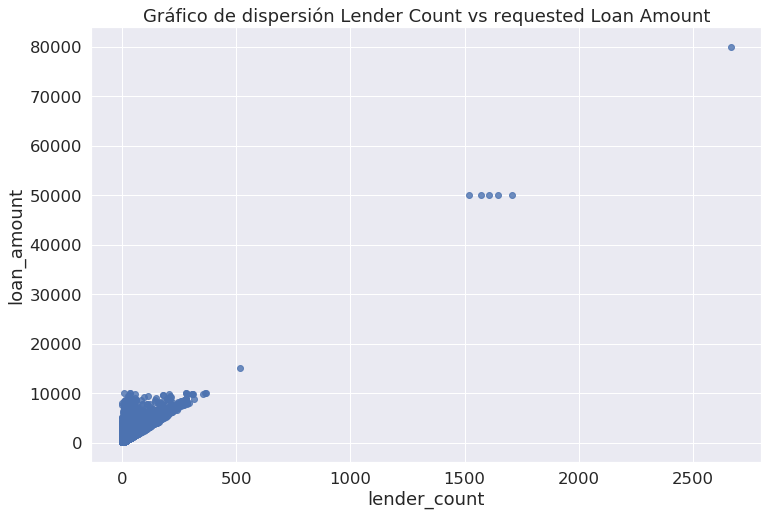

In [11]:
ax = sns.regplot(x=x_columns[0], y=y_column, data=df, fit_reg=False);
ax.set_title(f'Gráfico de dispersión {x_columns[0].replace("_", " ").title()} vs requested {y_column.replace("_", " ").title()}');
             

¿Cuál es la tendencia general?

¿Existen valores atípicos (outliers)?

-----
Normalidad
-----

Normalidad significa que la distribución de datos corresponde a una distribución normal.

El resumen de resultados anterior, nos da una idea de si nuestros datos se distribuyen normalmente o no. Si el número **Prob (JB)** es menor que 0.05, esto significa que podemos rechazar la hipótesis nula que establece que la distribución de datos es normal. Si este es el caso, tenemos que analizar nuestro modelo más de cerca para ver de dónde viene esto y cómo podemos corregir el problema.

Podemos visualizar la normalidad de los datos haciendo histogramas o gráficos Q-Q (cuantil-cuantil).

Primero veremos un histograma para la variable dependiente, loan_amount (monto del crédito). 
A partir de esto, podemos ver que la variable dependiente está sesgada a la izquierda.

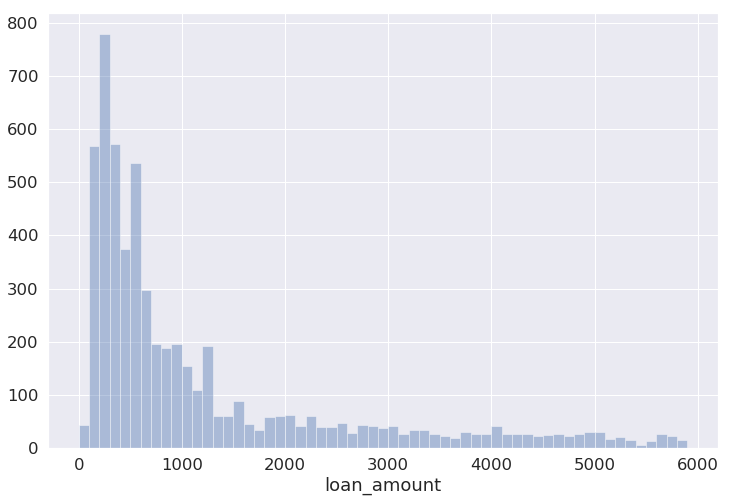

In [12]:
sns.distplot(df[df[y_column]<=6000][y_column], bins=range(0, 6000, 100), kde=False, norm_hist=False);

Además, podemos crear un gráfico cuantil-cuantil (Q-Q) para ver cómo la distribución de datos se compara con la esperada de una distribución normal. En estas gráficas, los cuantiles de los datos analizados se comparan con los de una distribución normal y si los datos analizados son normales, esperamos ver una línea recta. 

El gráfico a continuación muestra claramente que la variable dependiente no es normal y, por lo tanto, necesitamos investigar más el sesgo para ver si los datos requieren transformación.

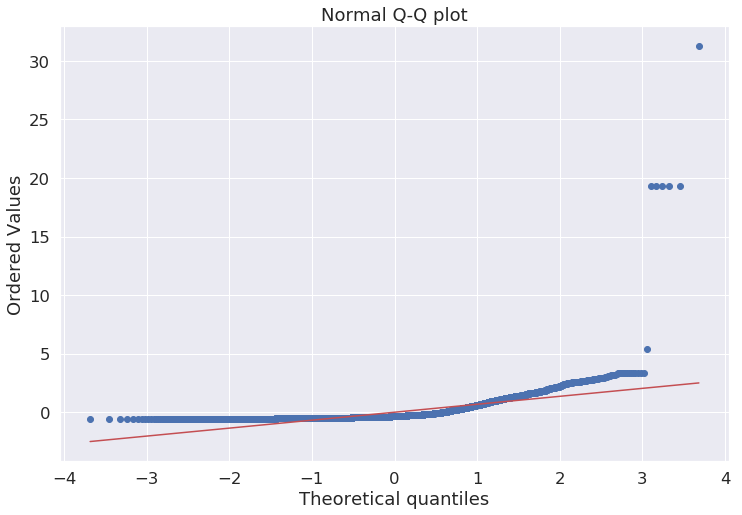

In [14]:
# Convertir la variable dependiente con numpy y estandarizar la data
y = np.asarray(df[y_column])
standardised_y = (y-np.mean(y))/np.std(y)

# crear un grafico Q-Q normal usando el modulo estadistico probplot

plt.figure(figsize=(12,8))
stats.probplot(standardised_y, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")
plt.show();

Si una variable no es normal, se puede ajustar mediante una [transformación no lineal](https://stats.stackexchange.com/questions/298/in-linear-regression-when-is-it-appropriate-to-use-the-log-of-an-independent-va).

Sabemos que nuestros datos están sesgados por valores atípicos, sin embargo, antes de comenzar a modelar, cuantifiquemos el grado en que están sesgados. 

[Paquete estadístico Scipy](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.stats.skew.html) nos permite realizar un test para evaluar el sesgo. El resultado de este test para un conjunto de datos normalmente distribuido devolvería aproximadamente 0. Un valor de asimetría mayor que 0 significa que hay más préstamos (loans) en la cola izquierda de la distribución. Típicamente, un puntaje sesgado de +-5 se considera aceptable. 

[Normalidad Multivariada](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) es una generalización de la normalidad unidimensional o univariada, a más dimensiones. Para una regresión que utiliza múltiples variables independientes (x), esto significa verificar que todas las combinaciones lineales de variables utilizadas son normales.

In [15]:
print(f"{stats.skew(df[y_column], axis=None):.4}")

11.81


Podemos continuar con el modelo de regresión lineal para predecir la cantidad del préstamo. Sin embargo, debemos ser conscientes de que nuestros coeficientes beta pueden ser __no__ confiables debido al sesgo de los datos.

__Si se enfrenta a un conjunto de datos con datos más sesgados, describimos una forma de abordar esto en el apéndice a continuación.__

### Multicolinealidad

La multicolinealidad solo es aplicable a la regresión multivariada, y significa que dos o más variables explicativas están altamente correlacionadas.

Esto dificulta que el modelo pueda diferenciar la influencia de las variables explicativas (o variables independiente) sobre la variable que se quiere analizar (variable dependiente).

Nuevamente, la tabla resumen de la regresión lineal puede ayudarnos. Hay un estadístico en la esquina inferior derecha conocido como **condition number**. Esto indica la gravedad y el impacto de la multicolinealidad en la regresión y, como regla general, los valores superiores a 30 son un problema.

Una forma de verificar esto es examinando la matriz de correlación y asegurándose de que ninguna de las variables tenga una correlación de 1. La función Corrcoef de Numpy devuelve la matriz con los coeficientes de correlación de Pearson.


Para mayor información sobre Numpy's Corrcoef [pulse aquí](https://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.corrcoef.html).

Nos tomaría mucho tiempo probar todas y cada una de las relaciones entre dos conjuntos de variables, así que creemos una matriz de correlación que nos permita visualizar cada correlación en un conjunto de datos usando Pandas.

In [16]:
df_corr_tbl = df[df.columns]
df_corr_tbl.corr()

,id_number,loan_amount,lender_count,funded_amount,repayment_term
id_number,1.000000,-0.099763,-0.131498,-0.138011,-0.087624
loan_amount,-0.099763,1.000000,0.904552,0.958558,-0.112723
lender_count,-0.131498,0.904552,1.000000,0.939418,-0.049583
funded_amount,-0.138011,0.958558,0.939418,1.000000,-0.100966
repayment_term,-0.087624,-0.112723,-0.049583,-0.100966,1.000000


In [17]:
for col in df.columns:
    print(col)

id_number
loan_amount
lender_count
status
funded_date
funded_amount
repayment_term
location_country_code
sector
description
use


Usando la tabla de correlación anterior, podemos ver que la cantidad financiada (funded_amount) está altamente correlacionada con el monto de préstamos (loan_amount) y  el lender_count. Entonces, para evitar la multicolinealidad, probablemente no queramos incluir funded_amount en ningún modelo de regresión multivariante.

### Sin autocorrelación

Una variable tiene autocorrelación cuando los valores en la serie se correlacionan con otros en la misma serie, separados por un intervalo dado. 

En términos de los residuos, esto significa verificar que los residuos son independientes. 

Una comprobación para esto es la **prueba de Durbin-Watson**. El estadístico durbin-watson varía de 0 a 4 con valores alrededor de 2 que sugieren que no hay autocorrelación. Los valores <2 sugieren correlación positiva y los valores> 2 sugieren correlación negativa. 

En la tabla de resumen anterior, la prueba de Durbin-Watson tiene un valor de aproximadamente 2, por lo que podemos estar felices de que no haya autocorrelación.

### Homocedasticidad

La homocedasticidad es un término estadístico que significa que la dispersión de los residuos es igual a través de la línea de regresión. Esta suposición significa que la varianza alrededor de la línea de regresión es la misma para todos los valores de la variable predictora (X).

Nuevamente, la tabla resumen de la regresión lineal nos permite evaluar si el modelo tiene homocedasticidad. Si el número **Prob (Omnibus)** es menor que 0.05, podemos rechazar la Hipótesis nula de que los residuos se distribuyen uniformemente y normalmente alrededor de cero.

En el caso anterior, el Prob (Omnibus) es 0.00, lo que indica claramente que el modelo no tiene homocedasticidad.

Esto se puede ver en el gráfico a continuación, la distribución de los residuos no son consistentes en el rango de datos. Cuando x es más pequeño, el residuo es más alto, y cuando x es más grande, el residuo es más pequeño. Por lo tanto, ¡debemos trabajar más en nuestro modelo de regresión!


[(0, 10000)]

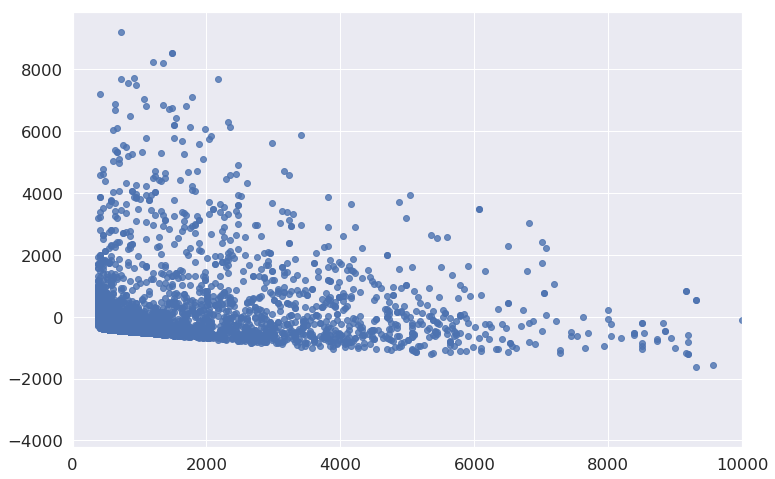

In [18]:
y_pred = model.predict(X_train)
ax = sns.regplot(x=y_pred, y=(y_train-y_pred), fit_reg=False)
ax.set(xlim=(0, 10000))

Resumen
----

Para recapitular los hallazgos de los supuestos de regresión lineal verificados arriba:

1. Relación lineal entre x e y
   - Para la variable independiente 'lender_count' existe relación lineal.
1. Normalidad
   - Los datos de la variable dependiente no se distribuyen normal y están sesgados a la izquierda.
1. Multicolinealidad mínima
   - Existe una multicolinealidad entre funded_amount y algunos otros predictores, por lo que debemos tenerlo en cuenta cuando realizamos una regresión multivariada.
1. Sin autocorrelación
   - La prueba de Durbin-Watson indica que no hay autocorrelación.
1. Homocedasticidad
   - Con la única variable independiente lender_count, el modelo no es homoscedastico.

<br>
<br> 
<br>
----